In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math

dfL1 = pd.read_csv('https://media.githubusercontent.com/media/joaoascensao/S-L-REL606-BarSeq/master/E_F/data/bc_counts/FL1_counts.csv')
r_totL1 = pd.read_csv('https://media.githubusercontent.com/media/joaoascensao/S-L-REL606-BarSeq/master/E_F/data/bc_counts/FL1_Rtot.csv')
outliersL1 = pd.read_csv('https://media.githubusercontent.com/media/joaoascensao/S-L-REL606-BarSeq/master/E_F/data/outliers/FL1_outliers.csv')

RD_threshold=6 # defined in SI (sec S3.5) of Ascensao et al 2022
cond1=outliersL1['RD'] > RD_threshold
cond2=outliersL1['RD'] == -1
outliersL1=outliersL1[cond1 | cond2]
dfL1 = dfL1[~dfL1.barcode.isin(outliersL1.barcode)]


gene_index = []
for gene in dfL1["gene_ID"]:
    gene_index.append(gene)
#df.index = gene_index
dfL1.dropna(subset = ["gene_ID"], inplace = True)
dfL1 = dfL1.reset_index() 

all_genes = [] #list of all gene_IDs
for gene in gene_index:
    if gene != "NaN" and gene != "nan" and gene not in all_genes:
        all_genes.append(gene)
all_genes.pop(0)
print(len(all_genes))
print(len(dfL1))
r_totL1 = r_totL1.iloc[: , 1:]


dfL1.head()


3252
71763


,index,barcode,0_1,0_2,1,2,3,4,strand,pos,gene_ID,type,gene_symbol,description
0,20,ACAGCCTCCTTGCAAAGTCC,258,339,363,315,347,364,+,566047.0,ECB_00522,cds,nfrA,"bacteriophage N4 receptor, outer membrane subunit"
1,21,TAACCTCCCTCAGTGATTCT,7,29,0,3,41,0,+,380163.0,ECB_00344,cds,araJ,predicted transporter
2,22,TCGAGATTTCGTGCGAAGGA,256,271,294,259,355,369,-,4316396.0,ECB_03987,cds,adiY,DNA-binding transcriptional activator
3,24,TCGACTTGACGGTCCAAATC,33,12,18,13,10,38,+,4486663.0,ECB_04141,cds,yjhB,predicted transporter
4,25,CATGACATAGTTTGGTATCA,17,17,33,4,0,0,+,2314185.0,ECB_02180,cds,yfbF,undecaprenyl phosphate-L-Ara4FN transferase


In [2]:
all_dfs = {} #dictionary of gene_ID to corresponding dataframe

for gene in all_genes:            
    all_dfs[gene] = dfL1[dfL1.gene_ID == gene]      

In [3]:
# a graph with trajectory of all gene frequencies
#for key in all_dfs.keys():
#    plot_freq(freq_over_days(all_dfs[key]), key)

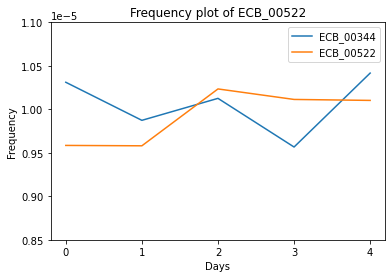

In [4]:
RtotL1_dict = dict(zip(r_totL1.columns.values, r_totL1.iloc[0].values))

#days
days = [0, 1, 2, 3, 4]

#function that takes the frequency average of a column (for a certain day)
def avg_freq(df, day, Rtot_dict):
    freq_vals = [] #all frequency values
    for count in df[day]:
        freq = count/Rtot_dict[day]
        freq_vals.append(freq)
    avg = np.sum(freq_vals)/len(freq_vals) #avg of all frequency values
    return avg
    
#function that yields average frequency of all barcodes in a single gene over 5 days (0-4 days)
def freq_over_days(df, Rtot_dict):
    all_freqs = []
    for day in ["0_1","0_2","1","2","3","4"]:
        all_freqs.append(avg_freq(df, day, Rtot_dict))
    day0 = (all_freqs[0]+all_freqs[1])/2
    all_freqs.pop(0)
    all_freqs.pop(0)
    all_freqs.insert(0, day0)
    #print(all_freqs)
    return all_freqs

##
def plot_freq(freq_array, gene):
    days = [0, 1, 2, 3, 4]
    plt.plot(days, freq_array, label = gene)
    plt.xticks(np.arange(0,len(days),1))
    plt.ylim([0.85e-5,1.1e-5])
    plt.xlabel("Days")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("Frequency plot of ECB_00522")
    
plot_freq(freq_over_days(all_dfs["ECB_00344"], RtotL1_dict),"ECB_00344")
plot_freq(freq_over_days(all_dfs["ECB_00522"], RtotL1_dict), "ECB_00522")

In [5]:
def discard(df):
    to_discard = []
    for i in range(len(df)):
        sum = 0
        for day in ["0_1","0_2","1","2","3","4"]:
            sum += df.loc[i,day] 
        if sum/6 < 30: #average count across days is < 30 --> discard
            to_discard.append(i)
    return to_discard

dfL1_dropped = dfL1.copy()

dfL1_dropped.drop(labels=discard(dfL1), axis=0, inplace=True)
dfL1_dropped =  dfL1_dropped.groupby('gene_ID').filter(lambda x : len(x)>3)
print(len(discard(dfL1)))
dfL1_dropped = dfL1_dropped.reset_index() 
print(len(dfL1_dropped))
dfL1_dropped.head(50)

19995
49540


,level_0,index,barcode,0_1,0_2,1,2,3,4,strand,pos,gene_ID,type,gene_symbol,description
0,0,20,ACAGCCTCCTTGCAAAGTCC,258,339,363,315,347,364,+,566047.0,ECB_00522,cds,nfrA,"bacteriophage N4 receptor, outer membrane subunit"
1,2,22,TCGAGATTTCGTGCGAAGGA,256,271,294,259,355,369,-,4316396.0,ECB_03987,cds,adiY,DNA-binding transcriptional activator
2,5,26,ATTCGTCCTCGTGTCGTCGA,190,122,123,177,144,149,-,273423.0,ECB_00246,cds,yagU,conserved inner membrane protein
3,6,29,TCCCATACGACCGATTCCAA,130,97,91,84,102,65,+,3671642.0,ECB_03425,cds,yiaI,"predicted hydrogenase, 4Fe-4S ferredoxin-type ..."
4,7,31,ATGGATATAGACTTACATGA,89,118,181,86,151,112,+,3120787.0,ECB_02916,cds,yqiG,predicted outer membrane usher protein
5,8,32,TACATACAACTTGCTCCAAC,237,232,214,272,260,295,+,556109.0,ECB_00513,cds,NaN,conserved hypothetical protein
6,9,33,TCACTTGACAATCACGTCCC,156,149,237,172,250,97,-,782097.0,ECB_00722,cds,ybhH,hypothetical protein
7,14,39,GGCCCCCGCGCTTAAGCCCA,27,56,29,34,56,30,-,263938.0,ECB_00238,cds,phoE,outer membrane phosphoporin protein E
8,15,40,TGATGTTGTAAAGCTCTCGG,63,48,58,31,35,33,-,2465868.0,ECB_02318,cds,pdxK,pyridoxine kinase
9,16,42,CTCCCACTCCGCTAAGGCTT,189,234,201,333,234,129,-,1538771.0,ECB_01447,cds,dos,"cAMP phosphodiesterase, heme-regulated"


In [6]:
#dictionary with days and corresponding Rtot
RtotL1_dict = dict(zip(r_totL1.columns.values, r_totL1.iloc[0].values))

dfL1_freqs = dfL1_dropped.copy() #df with freqs of all days

for day in ["0_1","0_2","1","2","3","4"]:
    freq_vals = [] #all frequency values
    for count in dfL1_freqs[day]:
        freq = count/RtotL1_dict[day]
        freq_vals.append(freq)
    dfL1_freqs["%s_freq" % day] = freq_vals
    


#df_freqs["0_freq"] = df_freqs[["0_1_freq", "0_2_freq"]].mean(axis=1)
dfL1_freqs.insert(15, "0_freq", dfL1_freqs[["0_1_freq", "0_2_freq"]].mean(axis=1))
dfL1_freqs = dfL1_freqs.drop("0_1_freq", 1)
dfL1_freqs = dfL1_freqs.drop("0_2_freq", 1)
dfL1_freqs.head(50)

,level_0,index,barcode,0_1,0_2,1,2,3,4,strand,pos,gene_ID,type,gene_symbol,description,0_freq,1_freq,2_freq,3_freq,4_freq
0,0,20,ACAGCCTCCTTGCAAAGTCC,258,339,363,315,347,364,+,566047.0,ECB_00522,cds,nfrA,"bacteriophage N4 receptor, outer membrane subunit",0.000022,2.642842e-05,0.000023,0.000023,2.924355e-05
1,2,22,TCGAGATTTCGTGCGAAGGA,256,271,294,259,355,369,-,4316396.0,ECB_03987,cds,adiY,DNA-binding transcriptional activator,0.000020,2.140483e-05,0.000019,0.000023,2.964524e-05
2,5,26,ATTCGTCCTCGTGTCGTCGA,190,122,123,177,144,149,-,273423.0,ECB_00246,cds,yagU,conserved inner membrane protein,0.000012,8.955083e-06,0.000013,0.000009,1.197057e-05
3,6,29,TCCCATACGACCGATTCCAA,130,97,91,84,102,65,+,3671642.0,ECB_03425,cds,yiaI,"predicted hydrogenase, 4Fe-4S ferredoxin-type ...",0.000008,6.625305e-06,0.000006,0.000007,5.222062e-06
4,7,31,ATGGATATAGACTTACATGA,89,118,181,86,151,112,+,3120787.0,ECB_02916,cds,yqiG,predicted outer membrane usher protein,0.000008,1.317781e-05,0.000006,0.000010,8.998014e-06
5,8,32,TACATACAACTTGCTCCAAC,237,232,214,272,260,295,+,556109.0,ECB_00513,cds,NaN,conserved hypothetical protein,0.000017,1.558039e-05,0.000020,0.000017,2.370013e-05
6,9,33,TCACTTGACAATCACGTCCC,156,149,237,172,250,97,-,782097.0,ECB_00722,cds,ybhH,hypothetical protein,0.000011,1.725492e-05,0.000012,0.000016,7.792923e-06
7,14,39,GGCCCCCGCGCTTAAGCCCA,27,56,29,34,56,30,-,263938.0,ECB_00238,cds,phoE,outer membrane phosphoporin protein E,0.000003,2.111361e-06,0.000002,0.000004,2.410182e-06
8,15,40,TGATGTTGTAAAGCTCTCGG,63,48,58,31,35,33,-,2465868.0,ECB_02318,cds,pdxK,pyridoxine kinase,0.000004,4.222722e-06,0.000002,0.000002,2.651201e-06
9,16,42,CTCCCACTCCGCTAAGGCTT,189,234,201,333,234,129,-,1538771.0,ECB_01447,cds,dos,"cAMP phosphodiesterase, heme-regulated",0.000016,1.463392e-05,0.000024,0.000015,1.036378e-05


In [7]:
dfL1_x = dfL1_freqs.copy() #df with freqs of VST (variance stabilizing transformation)

for freq in ["0_freq","1_freq","2_freq","3_freq","4_freq"]:
    x_vals = [] #all frequency values
    for count in dfL1_x[freq]:
        count = np.sqrt(count)
        x_vals.append(count)
    dfL1_x["x(%s)" % freq] = x_vals
    
dfL1_x = dfL1_x.drop(dfL1_x.columns[[0, 1, 3, 4, 5, 6, 7, 8, 15, 16, 17, 18, 19]], axis=1) 
dfL1_x.head(50)


,barcode,strand,pos,gene_ID,type,gene_symbol,description,x(0_freq),x(1_freq),x(2_freq),x(3_freq),x(4_freq)
0,ACAGCCTCCTTGCAAAGTCC,+,566047.0,ECB_00522,cds,nfrA,"bacteriophage N4 receptor, outer membrane subunit",0.004696,0.005141,0.004759,0.004775,0.005408
1,TCGAGATTTCGTGCGAAGGA,-,4316396.0,ECB_03987,cds,adiY,DNA-binding transcriptional activator,0.004422,0.004627,0.004315,0.004830,0.005445
2,ATTCGTCCTCGTGTCGTCGA,-,273423.0,ECB_00246,cds,yagU,conserved inner membrane protein,0.003419,0.002993,0.003567,0.003076,0.003460
3,TCCCATACGACCGATTCCAA,+,3671642.0,ECB_03425,cds,yiaI,"predicted hydrogenase, 4Fe-4S ferredoxin-type ...",0.002912,0.002574,0.002457,0.002589,0.002285
4,ATGGATATAGACTTACATGA,+,3120787.0,ECB_02916,cds,yqiG,predicted outer membrane usher protein,0.002765,0.003630,0.002486,0.003150,0.003000
5,TACATACAACTTGCTCCAAC,+,556109.0,ECB_00513,cds,NaN,conserved hypothetical protein,0.004174,0.003947,0.004422,0.004133,0.004868
6,TCACTTGACAATCACGTCCC,-,782097.0,ECB_00722,cds,ybhH,hypothetical protein,0.003367,0.004154,0.003516,0.004053,0.002792
7,GGCCCCCGCGCTTAAGCCCA,-,263938.0,ECB_00238,cds,phoE,outer membrane phosphoporin protein E,0.001743,0.001453,0.001563,0.001918,0.001552
8,TGATGTTGTAAAGCTCTCGG,-,2465868.0,ECB_02318,cds,pdxK,pyridoxine kinase,0.002036,0.002055,0.001493,0.001517,0.001628
9,CTCCCACTCCGCTAAGGCTT,-,1538771.0,ECB_01447,cds,dos,"cAMP phosphodiesterase, heme-regulated",0.003955,0.003825,0.004893,0.003921,0.003219


In [8]:
dfL1_x_corr = dfL1_x.copy() #df with corrected freqs of VST (variance stabilizing transformation)
df_s = pd.read_csv('https://media.githubusercontent.com/media/joaoascensao/S-L-REL606-BarSeq/master/E_F/data/fitness/FL1_fitness.csv')
df_t_xbar = pd.read_csv('https://media.githubusercontent.com/media/joaoascensao/S-L-REL606-BarSeq/master/E_F/data/meanfitness/FL1_xbar.csv')

df_t_xbar.head()

,Unnamed: 0,Day label,xbar,stderr,gens
0,0,1,0.002590,0.000394,6.643856
1,1,2,0.001901,0.000187,13.287712
2,2,3,0.001533,0.000147,19.931569
3,3,4,0.001348,0.000134,26.575425


In [9]:
tL1_dict = {}
xbarL1_dict = {}

#dictionary of (day:generation)
for day, gen, xbar in zip(df_t_xbar["Day label"], df_t_xbar["gens"], df_t_xbar["xbar"]):
    tL1_dict[day] = gen
    xbarL1_dict[day] = xbar
print(tL1_dict)
print(xbarL1_dict)

{1: 6.64385619, 2: 13.28771238, 3: 19.93156857, 4: 26.57542476}
{1: 0.002589519873986117, 2: 0.001900750964939452, 3: 0.001533448030722952, 4: 0.0013481492998967974}


In [10]:
df_s.head(10)

,Unnamed: 0,gene_ID,type,gene_symbol,description,s,s std,pval,s significant,s corrected pval
0,0,ECB_00007,cds,yaaJ,predicted transporter,-0.016000,0.003576,0.000005,1,0.000155
1,1,ECB_00008,cds,talB,transaldolase B,-0.005448,0.010604,0.608248,0,0.805678
2,2,ECB_00010,cds,yaaH,conserved inner membrane protein associated wi...,-0.002409,0.005896,0.682845,0,0.850520
3,3,ECB_00013,cds,yaaI,hypothetical protein,-0.003773,0.007798,0.628700,0,0.818355
4,4,ECB_00019,cds,nhaR,DNA-binding transcriptional activator,0.001484,0.003241,0.647704,0,0.825968
5,5,ECB_00034,cds,rihC,ribonucleoside hydrolase 3,-0.005444,0.005773,0.344261,0,0.603221
6,6,ECB_00038,cds,caiF,DNA-binding transcriptional activator,0.003066,0.002422,0.207174,0,0.464163
7,7,ECB_00039,cds,caiE,predicted acyl transferase,-0.024682,0.008536,0.003039,1,0.030540
8,8,ECB_00040,cds,caiD,carnitinyl-CoA dehydratase,-0.000482,0.003005,0.872614,0,0.954380
9,9,ECB_00041,cds,caiC,crotonobetaine/carnitine-CoA ligase,-0.004363,0.002616,0.094019,0,0.279992


In [11]:
s_dict = {}

#dictionary of (gene_ID:s)
for gene, s in zip(df_s["gene_ID"], df_s["s"]):
    s_dict[gene] = s

In [12]:
s_dict = dict(zip(df_s["gene_ID"], df_s["s"]))

In [13]:
dfL1_x_corr = dfL1_x.copy()

#dropping rows/gene_IDs with no "s" value
no_s = []
for i in range(len(dfL1_x_corr)):
    index_gene = dfL1_x_corr.columns.get_loc("gene_ID")
    if dfL1_x_corr.iloc[i,index_gene] not in s_dict.keys():
        no_s.append(i)
dfL1_x_corr.drop(no_s, axis=0, inplace=True)
dfL1_x_corr = dfL1_x_corr.reset_index()
dfL1_x_corr = dfL1_x_corr.drop(dfL1_x_corr.columns[[0]], axis=1)

#calculating x_corrected
days = [1, 2, 3, 4]
x_freqs = ["x(1_freq)","x(2_freq)","x(3_freq)","x(4_freq)"]

def x_corr_form(day, x, s_dict, t_dict, xbar_dict, df_x_corr):
    x_corr_vals = []
    for i in range(len(df_x_corr)):
        #index = day-1
        index_0 = df_x_corr.columns.get_loc("x(0_freq)")
        index_t = df_x_corr.columns.get_loc(x)
        x_0 = df_x_corr.iloc[i, index_0]
        x_t = df_x_corr.iloc[i, index_t]
        index_gene = df_x_corr.columns.get_loc("gene_ID")
        gene_ID = df_x_corr.iloc[i, index_gene]
        if gene_ID in s_dict.keys():
            s = s_dict[gene_ID]
        else:
            continue;
        t = t_dict[day]
        xbar = xbar_dict[day]
        x_corr = x_corr_ele(x_0, x_t, s, xbar, t)
        x_corr_vals.append(x_corr)
    return x_corr_vals
        
def x_corr_ele(x_0, x_t, s, xbar, t):
    x_corr = x_t - (x_0*math.exp((s-xbar)* (t/2)))
    return x_corr


for day, x in zip(days, x_freqs):
    x_corr = x_corr_form(day, x, s_dict, tL1_dict, xbarL1_dict, dfL1_x_corr)
    dfL1_x_corr["x_corr(%s)" % day] = x_corr
    
print(len(dfL1_x_corr))
dfL1_x_corr.head(50)

42669


,barcode,strand,pos,gene_ID,type,gene_symbol,description,x(0_freq),x(1_freq),x(2_freq),x(3_freq),x(4_freq),x_corr(1),x_corr(2),x_corr(3),x_corr(4)
0,ACAGCCTCCTTGCAAAGTCC,+,566047.0,ECB_00522,cds,nfrA,"bacteriophage N4 receptor, outer membrane subunit",0.004696,0.005141,0.004759,0.004775,0.005408,0.000449,0.000050,0.000043,6.521642e-04
1,TCGAGATTTCGTGCGAAGGA,-,4316396.0,ECB_03987,cds,adiY,DNA-binding transcriptional activator,0.004422,0.004627,0.004315,0.004830,0.005445,0.000262,-0.000014,0.000531,1.175330e-03
2,ATTCGTCCTCGTGTCGTCGA,-,273423.0,ECB_00246,cds,yagU,conserved inner membrane protein,0.003419,0.002993,0.003567,0.003076,0.003460,-0.000399,0.000187,-0.000296,9.443076e-05
3,TCCCATACGACCGATTCCAA,+,3671642.0,ECB_03425,cds,yiaI,"predicted hydrogenase, 4Fe-4S ferredoxin-type ...",0.002912,0.002574,0.002457,0.002589,0.002285,-0.000256,-0.000307,-0.000114,-3.573905e-04
4,ATGGATATAGACTTACATGA,+,3120787.0,ECB_02916,cds,yqiG,predicted outer membrane usher protein,0.002765,0.003630,0.002486,0.003150,0.003000,0.000875,-0.000271,0.000386,2.297180e-04
5,TCACTTGACAATCACGTCCC,-,782097.0,ECB_00722,cds,ybhH,hypothetical protein,0.003367,0.004154,0.003516,0.004053,0.002792,0.000823,0.000206,0.000758,-4.876592e-04
6,GGCCCCCGCGCTTAAGCCCA,-,263938.0,ECB_00238,cds,phoE,outer membrane phosphoporin protein E,0.001743,0.001453,0.001563,0.001918,0.001552,-0.000272,-0.000151,0.000212,-1.453866e-04
7,TGATGTTGTAAAGCTCTCGG,-,2465868.0,ECB_02318,cds,pdxK,pyridoxine kinase,0.002036,0.002055,0.001493,0.001517,0.001628,0.000095,-0.000403,-0.000319,-1.497143e-04
8,CTCCCACTCCGCTAAGGCTT,-,1538771.0,ECB_01447,cds,dos,"cAMP phosphodiesterase, heme-regulated",0.003955,0.003825,0.004893,0.003921,0.003219,-0.000024,0.001129,0.000236,-3.889798e-04
9,GGCCCGCGCTTGCCACGACG,-,3384453.0,ECB_03176,cds,gspD,"general secretory pathway component, cryptic",0.001684,0.001453,0.001258,0.002114,0.001169,-0.000215,-0.000403,0.000460,-4.797799e-04


In [14]:
#list of all x_corr(t) for each barcode:
xL1_corrs = dfL1_x_corr[["x_corr(1)","x_corr(2)","x_corr(3)","x_corr(4)"]].values.tolist()

def x_var(x_corrs, df_x_corr):
    x_c_var = []
    for x_c in x_corrs:
        x_var = np.var(x_c)
        x_c_var.append(x_var)
    df_x_corr["var(x_corr)"] = x_c_var

x_var(xL1_corrs, dfL1_x_corr)
dfL1_x_corr.head(50)   

,barcode,strand,pos,gene_ID,type,gene_symbol,description,x(0_freq),x(1_freq),x(2_freq),x(3_freq),x(4_freq),x_corr(1),x_corr(2),x_corr(3),x_corr(4),var(x_corr)
0,ACAGCCTCCTTGCAAAGTCC,+,566047.0,ECB_00522,cds,nfrA,"bacteriophage N4 receptor, outer membrane subunit",0.004696,0.005141,0.004759,0.004775,0.005408,0.000449,0.000050,0.000043,6.521642e-04,6.865584e-08
1,TCGAGATTTCGTGCGAAGGA,-,4316396.0,ECB_03987,cds,adiY,DNA-binding transcriptional activator,0.004422,0.004627,0.004315,0.004830,0.005445,0.000262,-0.000014,0.000531,1.175330e-03,1.943884e-07
2,ATTCGTCCTCGTGTCGTCGA,-,273423.0,ECB_00246,cds,yagU,conserved inner membrane protein,0.003419,0.002993,0.003567,0.003076,0.003460,-0.000399,0.000187,-0.000296,9.443076e-05,6.204989e-08
3,TCCCATACGACCGATTCCAA,+,3671642.0,ECB_03425,cds,yiaI,"predicted hydrogenase, 4Fe-4S ferredoxin-type ...",0.002912,0.002574,0.002457,0.002589,0.002285,-0.000256,-0.000307,-0.000114,-3.573905e-04,8.278326e-09
4,ATGGATATAGACTTACATGA,+,3120787.0,ECB_02916,cds,yqiG,predicted outer membrane usher protein,0.002765,0.003630,0.002486,0.003150,0.003000,0.000875,-0.000271,0.000386,2.297180e-04,1.673148e-07
5,TCACTTGACAATCACGTCCC,-,782097.0,ECB_00722,cds,ybhH,hypothetical protein,0.003367,0.004154,0.003516,0.004053,0.002792,0.000823,0.000206,0.000758,-4.876592e-04,2.775411e-07
6,GGCCCCCGCGCTTAAGCCCA,-,263938.0,ECB_00238,cds,phoE,outer membrane phosphoporin protein E,0.001743,0.001453,0.001563,0.001918,0.001552,-0.000272,-0.000151,0.000212,-1.453866e-04,3.280263e-08
7,TGATGTTGTAAAGCTCTCGG,-,2465868.0,ECB_02318,cds,pdxK,pyridoxine kinase,0.002036,0.002055,0.001493,0.001517,0.001628,0.000095,-0.000403,-0.000319,-1.497143e-04,3.618475e-08
8,CTCCCACTCCGCTAAGGCTT,-,1538771.0,ECB_01447,cds,dos,"cAMP phosphodiesterase, heme-regulated",0.003955,0.003825,0.004893,0.003921,0.003219,-0.000024,0.001129,0.000236,-3.889798e-04,3.137916e-07
9,GGCCCGCGCTTGCCACGACG,-,3384453.0,ECB_03176,cds,gspD,"general secretory pathway component, cryptic",0.001684,0.001453,0.001258,0.002114,0.001169,-0.000215,-0.000403,0.000460,-4.797799e-04,1.370257e-07


In [15]:
#create df with variances and corresponding geneIDs
def list_genes(df_x_corr):
    updated_genes = []
    for gene in df_x_corr["gene_ID"].tolist():
        if gene not in updated_genes:
            updated_genes.append(gene)
    return updated_genes

#getting average variance of barcodes in each gene:
def avg_var(df_x_corr):
    avg_vars = []
    std_vars = []
    for gene in list_genes(df_x_corr):
        df_gene = df_x_corr.loc[df_x_corr["gene_ID"] == gene]
        x_vars = df_gene["var(x_corr)"].mean()
        avg_vars.append(x_vars)
        x_std = np.sqrt(x_vars)
        std_vars.append(x_std)
    return [avg_vars, std_vars]

bcL1_data = {"gene_ID": list_genes(dfL1_x_corr), "avg_var(x_corr)": avg_var(dfL1_x_corr)[0], "std(x_corr)": avg_var(dfL1_x_corr)[1]}
dfL1_bc = pd.DataFrame(bcL1_data)
dfL1_bc = dfL1_bc.sort_values(by = 'avg_var(x_corr)', ascending=[False])
dfL1_bc = dfL1_bc.reset_index() 
dfL1_bc.head(50)




,index,gene_ID,avg_var(x_corr),std(x_corr)
0,1404,ECB_03213,4.796041e-07,0.000693
1,971,ECB_02438,3.692117e-07,0.000608
2,1369,ECB_02112,3.662549e-07,0.000605
3,560,ECB_00878,3.415944e-07,0.000584
4,1722,ECB_00267,3.366852e-07,0.000580
5,1365,ECB_03112,3.232132e-07,0.000569
6,1282,ECB_01702,3.075848e-07,0.000555
7,1064,ECB_00883,3.040116e-07,0.000551
8,1327,ECB_02708,3.028509e-07,0.000550
9,1203,ECB_02521,2.964944e-07,0.000545


In [16]:
dfL1_bc.to_csv('FL1.csv')

In [17]:
#df_x_corr
#first 3 genes with highest variance:
def plot_x(df_gene, gene_ID):
    for i in range(len(df_gene)):
        barcode = df_gene.iloc[i,0]
        x_array = df_gene.iloc[i,8:12].tolist()
        days = [1, 2, 3, 4]
        plt.plot(days, x_array)#, label = barcode)
        plt.xticks(np.arange(1,len(days)+1,1))
        plt.xlabel("Days")
        plt.ylabel("x(t)")
        plt.ylim([-0.02,0.02])
        #plt.legend()
        plt.title(gene_ID)
    plt.show()
    
def plot_x_corr(df_gene, gene_ID):
    for i in range(len(df_gene)):
        barcode = df_gene.iloc[i,0]
        x_array = df_gene.iloc[i,12:16].tolist()
        days = [1, 2, 3, 4]
        plt.plot(days, x_array)#, label = barcode)
        plt.xticks(np.arange(1,len(days)+1,1))
        plt.xlabel("Days")
        plt.ylabel("x_corr(t)")
        plt.ylim([-0.02,0.02])
        #plt.legend()
        plt.title(gene_ID)
    plt.show()

def plot_gene_x(gene_ID, df_x_corr):
    #gene_ID = df_bc.iloc[i, 1] #1 is index of gene_ID
    df_gene = df_x_corr.loc[df_x_corr["gene_ID"] == gene_ID]
    plot_x(df_gene, gene_ID)
    
def plot_gene_x_corr(gene_ID, df_x_corr):
    #gene_ID = df_bc.iloc[i, 1] #1 is index of gene_ID
    df_gene = df_x_corr.loc[df_x_corr["gene_ID"] == gene_ID]
    plot_x_corr(df_gene, gene_ID)

In [18]:
def plot_first(df_bc, df_x_corr, n): #number of first nth genes to plot for df_bc
    gene_order = df_bc["gene_ID"].tolist()
    for gene in gene_order[0:n]:
        plot_gene_x(gene, df_x_corr)
        plot_gene_x_corr(gene, df_x_corr)
        
def plot_last(df_bc, df_x_corr, n): #number of first nth genes to plot for df_bc
    gene_order = df_bc["gene_ID"].tolist()
    for gene in gene_order[-n:]:
        plot_gene_x(gene, df_x_corr)
        plot_gene_x_corr(gene, df_x_corr)

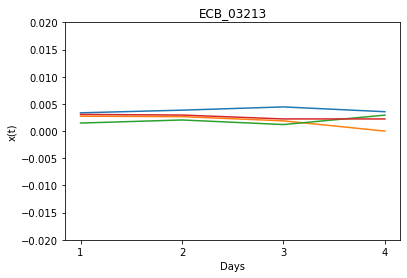

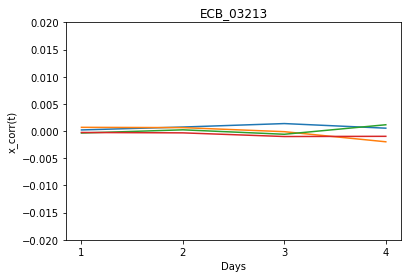

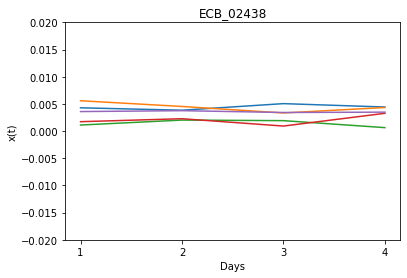

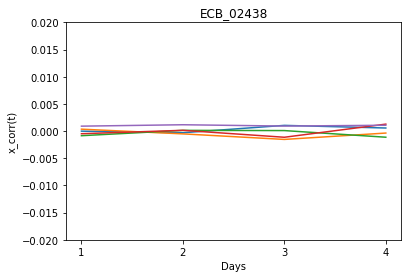

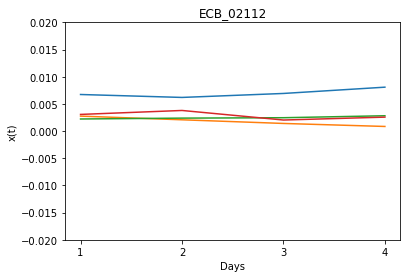

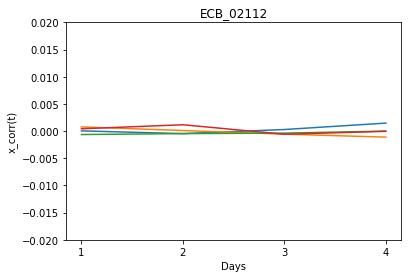

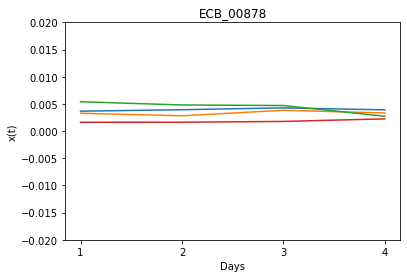

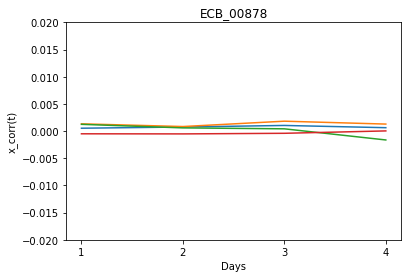

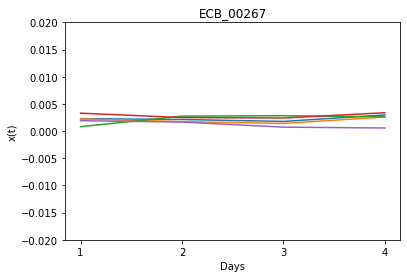

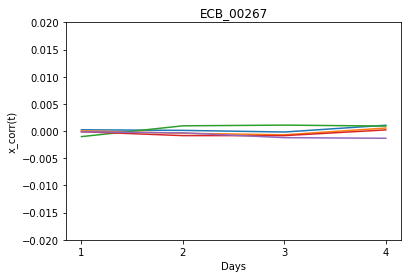

In [19]:
plot_first(dfL1_bc, dfL1_x_corr, 5)

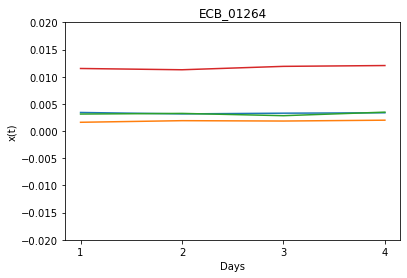

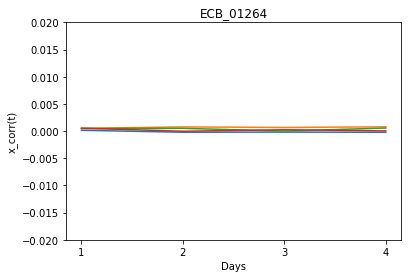

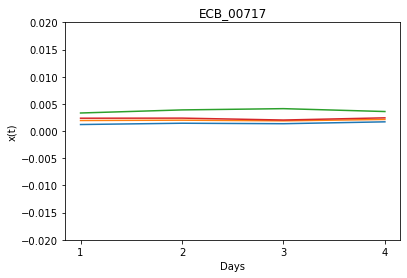

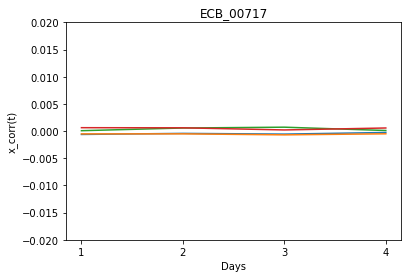

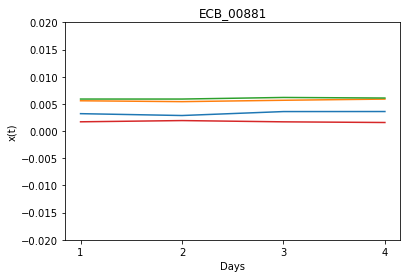

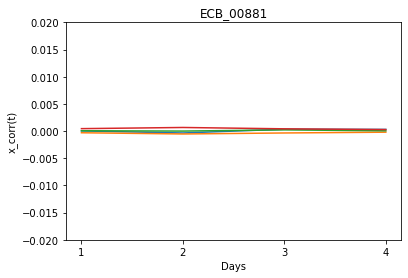

In [20]:
plot_last(dfL1_bc, dfL1_x_corr, 3)